In [1]:
from pathlib import Path
from os import listdir
from os.path import isfile, join
from pybeerxml import Parser
import sys
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
sys.path.append('../')
from brewgen.backend.models import grain

In [2]:
# Get all recipe paths
beerxml_list = list(Path("./brewtoad_scrape").rglob("*.xml"))

In [3]:
parser = Parser()
recipe_db = []

In [45]:
rewrites = [
    {
        'name': 'Goldpils Vienna Malt',
        'match': "^.*(Goldpils|Vienna.*US|US.*Vienna|Briess.*Vienna|Vienna.*Briess).*$",
        'max_color': 6
    },
    # Weyermann as the catchall for Vienna
    {
        'name': 'Weyermann Vienna Malt',
        'match': '^.*Vienna.*$',
        'max_color': 6
    }, {
        'name': 'Weyermann Munich Malt I',
        "match": '^.*Munich.*$',
        'max_color': 7
    },
    {
        'name': 'Weyermann Munich Malt II',
        "match": '^.*Munich.*$',
        'max_color': 9.9
    },
    {
        'name': 'Munich Malt 10L',
        "match": '^.*Munich.*$',
        'max_color': 11
    },
    {
        'name': 'Munich Malt 20L',
        "match": '^.*Munich.*$',
        'max_color': 21
    },
    {
        'name': "Brewer's Malt",
        'match': '^.*(2|Two)(-| )Row.*$',
        'max_color': 2
    },
    # No sensory available for Maris Otter so lumping that in with Pale Ale Malt
    {
        'name': "Pale Ale Malt",
        'match': '^.*(Pale Ale|Maris).*$',
        'max_color': 5
    },
    {
        'name': "Carapils Malt",
        'match': '^.*(US.*Carapils|Carapils.*US|Carapils.*Briess|Briess.*Carapils).*$',
        'max_color': 5
    },
    # Weyermann as the catchall for Carapils
    {
        'name': "Weyermann Carapils",
        'match': '^.*(Carapils).*$',
        'max_color': 5
    },
    {
        'name': "Pilsen Malt",
        'match': '^.*(Pilsen|US.*Pilsner|Pilsner.*US).*$',
        'max_color': 3
    },
    # Weyermann as the catchall for Pilsner
    {
        'name': "Weyermann Pilsner Malt",
        'match': '^.*Pilsner.*$',
        'max_color': 3
    },
        {
        'name': "Pale Chocolate Malt",
        'match': '^.*Chocolate.*$',
        'max_color': 240
    },
            {
        'name': "Chocolate Malt",
        'match': '^.*Chocolate.*$',
        'max_color': 360
    },
    {
        'name': "Dark Chocolate Malt",
        'match': '^.*Chocolate.*$',
        'max_color': 430
    }
]

# Add rewrites for each Crystal malt
for lov in [10, 20, 30, 40, 60, 80, 90, 120]:
    rewrites.append({
        'name': 'Caramel Malt {}L'.format(lov),
        'match': '^.*(Caramel|Crystal).*{}.*$'.format(lov)
    })

In [46]:
for beerxml_file in beerxml_list[0:100000]:
    try:
        recipes = parser.parse('./{}'.format(str(beerxml_file)))
    except:
        print("Failed to parse ./{}".format(str(beerxml_file)))
        recipes = []
    
    for recipe in recipes:
        try:
            style = recipe.style.name
            fermentables = []
            total_amount = sum(
                fermentable.amount for fermentable in recipe.fermentables)
            for fermentable in recipe.fermentables:
                fermentable_name = fermentable.name
                # Remove all LME/DME
                extract = re.match("^.*(DME|LME|Extract).*$", fermentable_name)
                if extract:
                    #print('Skipping extract: {}'.format(fermentable_name))
                    break
                
                # Rewrite fermentable names
                for rule in rewrites:
                    match = re.match(rule['match'], fermentable.name)
                    if match and fermentable.color <= rule.get('max_color', 100):
                        #print('Rewriting {} -> {}'.format(fermentable_name, rule['name']))
                        fermentable_name = rule['name']
                        break

                fermentables.append({
                    'name': fermentable_name,
                    'percent': fermentable.amount / total_amount * 100,
                    'color': fermentable.color,
                    'ppg': fermentable.ppg,
                    'addition': fermentable.addition,
                })
            recipe_db.append({
                'style': style,
                'category': recipe.style.category,
                'og': recipe.og,
                'color': recipe.color,
                'fermentables': fermentables
            })
        except:
            print("Failed to parse recipe in ./{}".format(str(beerxml_file)))

Failed to parse ./brewtoad_scrape/recipes/beginers-luck-ipa-2012-02-19-vers/recipe.xml
Failed to parse ./brewtoad_scrape/recipes/ipa-2-huell-melon-galaxy/recipe.xml
Failed to parse ./brewtoad_scrape/recipes/cascadia-pale-ale-20/recipe.xml
Failed to parse ./brewtoad_scrape/recipes/delta-hoppy-blonde/recipe.xml
Failed to parse ./brewtoad_scrape/recipes/seriously-mild/recipe.xml


In [47]:
# Get an array of styles and color histogram data
styles = np.unique(np.array([recipe['style'] for recipe in recipe_db]))
color_data = [[recipe['color'] for recipe in recipe_db if recipe['style'] == style] for style in styles]

In [48]:
# Create a list of list of dicts containing grains and their usage percents for every style and recipe
# [Style:[Grains:{Name, Usage Percent}]]
fermentable_data = []
for i in range(len(styles)):
    fermentable_style_data = []
    recipe_fermentables = [recipe['fermentables'] for recipe in recipe_db if recipe['style'] == styles[i]]
    for recipe in recipe_fermentables:
        for fermentable in recipe:
            fermentable_style_data.append(fermentable)
    fermentable_data.append(fermentable_style_data)

In [49]:
# # Histograms for the SRM data for each style
# plt.xlabel('SRM')
# plt.ylabel('Counts')
# bins = range(0, 101)
# for i in range(len(styles)):
#     data = color_data[i]
#     plt.title(styles[i])
#     plt.hist(color_data[i], bins=bins)
#     plt.show()
#     std_dev = np.std(color_data[i])
#     mean = np.mean(color_data[i])
#     print('Mean: {}'.format(mean))
#     print('Standard Dev: {}'.format(std_dev))
#     print('Range (1 std dev): {} - {}'.format(mean - .5 * std_dev, mean + .5 * std_dev))

In [50]:
# Plot grain usage for each style 
for style in range(len(styles)):
    # Only calculate for American Pale Ale for now
    if styles[style] == 'American IPA':
        # Get unique fermentable names
        names = [fermentable['name'] for fermentable in fermentable_data[style]]
        unique_names = list(set(names))
        fermentable_usage = []
        for name in range(len(unique_names)):
            usage_list = [fermentable['percent'] for fermentable in fermentable_data[style] if fermentable['name'] == unique_names[name]]
            fermentable_usage.append((unique_names[name],usage_list))
            
# Sort by the most common grain names, then plot usage averages
sorted_usage = sorted(fermentable_usage, key=lambda tup: len(tup[1]), reverse=True)

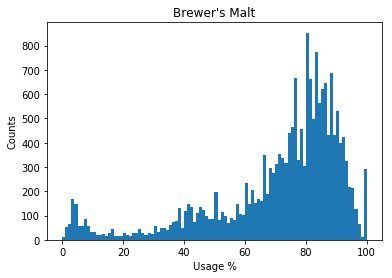

Mean: 71.29177465365939
Standard Dev: 21.878212236934072
Range (3 std dev): 5-100%


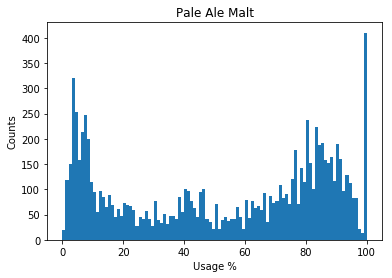

Mean: 52.82396457465561
Standard Dev: 33.49938177806865
Range (3 std dev): 0-100%


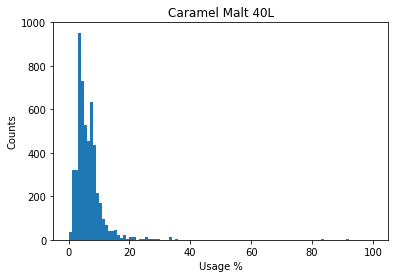

Mean: 6.29408138266749
Standard Dev: 4.453923306166579
Range (3 std dev): 0-19%


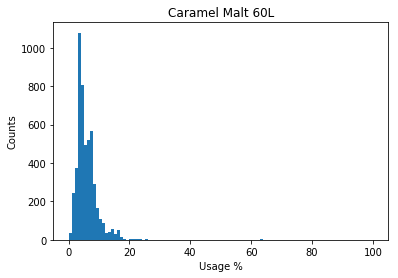

Mean: 5.802843549159076
Standard Dev: 3.408479367284039
Range (3 std dev): 0-16%


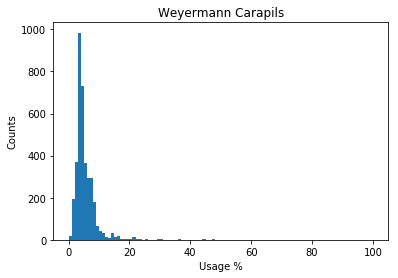

Mean: 5.282070607664587
Standard Dev: 3.5650365539032745
Range (3 std dev): 0-15%


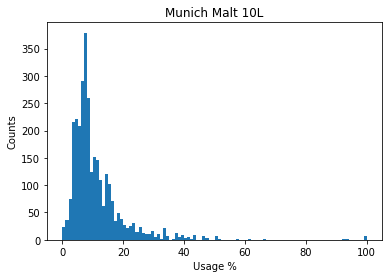

Mean: 11.183364678968735
Standard Dev: 9.721027932392168
Range (3 std dev): 0-40%


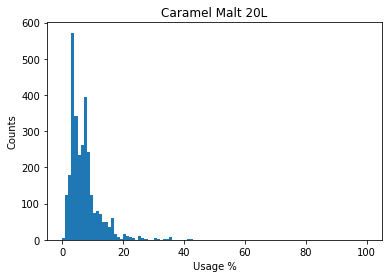

Mean: 7.1015116577150925
Standard Dev: 4.829222918989178
Range (3 std dev): 0-21%


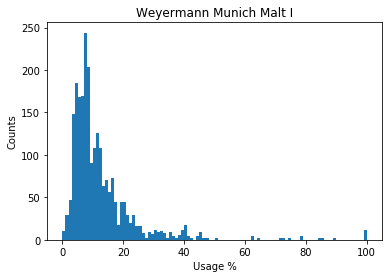

Mean: 12.516184907429274
Standard Dev: 12.176760807317748
Range (3 std dev): 0-49%


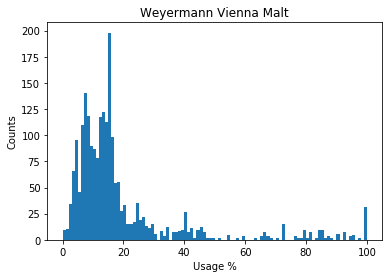

Mean: 19.295465495176384
Standard Dev: 20.160672575155868
Range (3 std dev): 0-79%


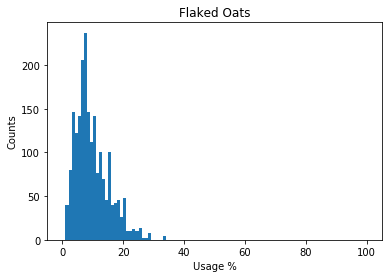

Mean: 9.696622125377827
Standard Dev: 5.4734881630837755
Range (3 std dev): 0-26%


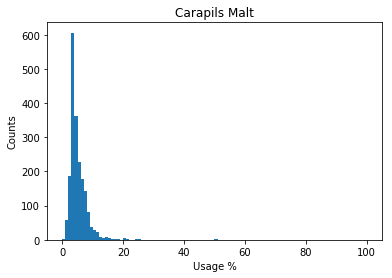

Mean: 5.163200990345934
Standard Dev: 3.0316127887588755
Range (3 std dev): 0-14%


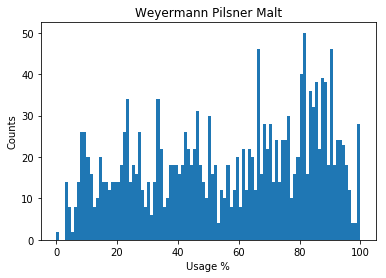

Mean: 56.284287364303076
Standard Dev: 27.588184450416257
Range (3 std dev): 0-100%


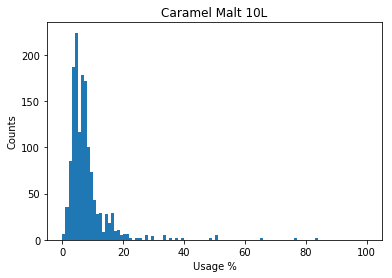

Mean: 7.8304458376506005
Standard Dev: 7.259150046703428
Range (3 std dev): 0-29%


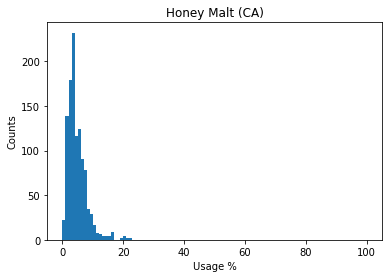

Mean: 4.7843955827121345
Standard Dev: 3.1919439541104113
Range (3 std dev): 0-14%


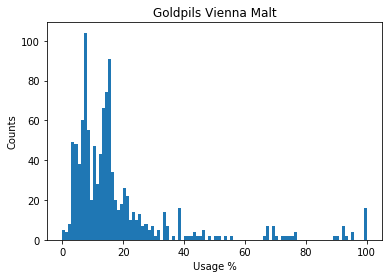

Mean: 18.27735474388069
Standard Dev: 19.02251089735625
Range (3 std dev): 0-75%


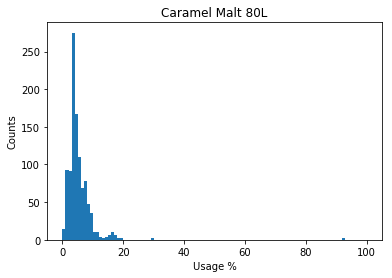

Mean: 5.320263544480748
Standard Dev: 5.019024835688027
Range (3 std dev): 0-20%


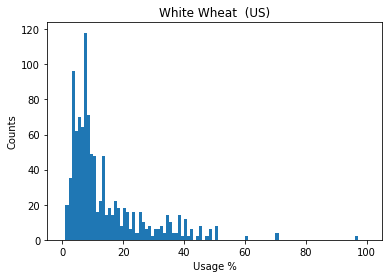

Mean: 13.717656895504376
Standard Dev: 12.395089984663374
Range (3 std dev): 0-50%


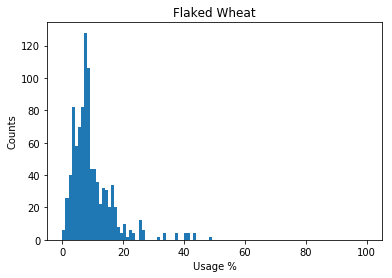

Mean: 9.670419055819336
Standard Dev: 6.995792504034646
Range (3 std dev): 0-30%


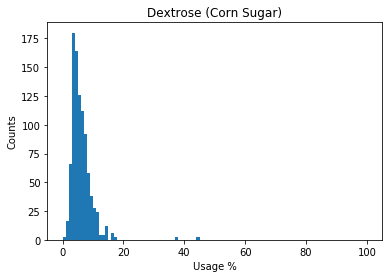

Mean: 6.047107004907823
Standard Dev: 3.577417612380609
Range (3 std dev): 0-16%


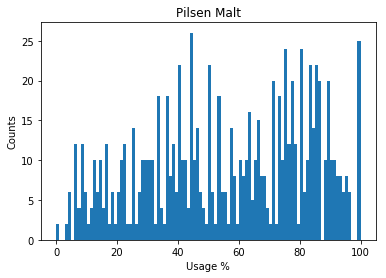

Mean: 56.428154272094346
Standard Dev: 26.562855626483604
Range (3 std dev): 0-100%


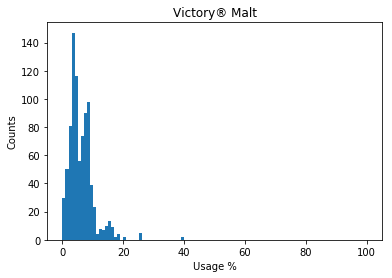

Mean: 6.111140574236258
Standard Dev: 4.1226923774159445
Range (3 std dev): 0-18%


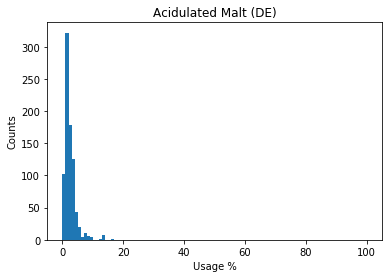

Mean: 2.553987505786813
Standard Dev: 2.0145741082699993
Range (3 std dev): 0-8%


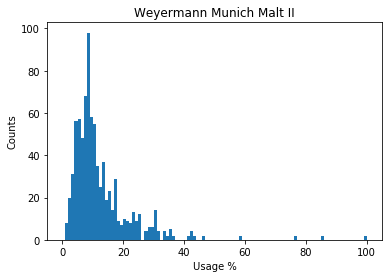

Mean: 12.524068545421475
Standard Dev: 10.548632252076004
Range (3 std dev): 0-44%


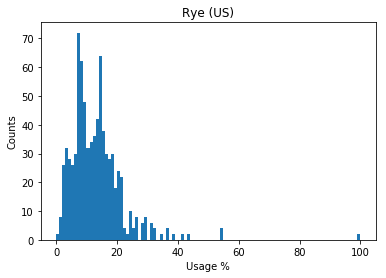

Mean: 13.196953036084818
Standard Dev: 8.877794706188876
Range (3 std dev): 0-39%


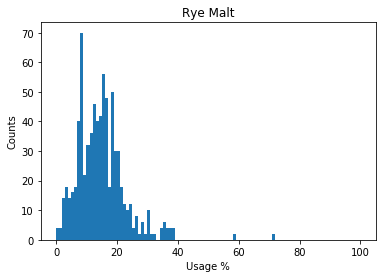

Mean: 14.82883195577012
Standard Dev: 8.103786699607305
Range (3 std dev): 0-39%


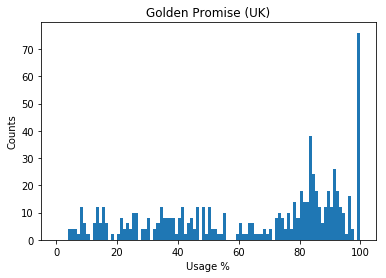

Mean: 64.57038702253834
Standard Dev: 29.39943940265272
Range (3 std dev): 0-100%


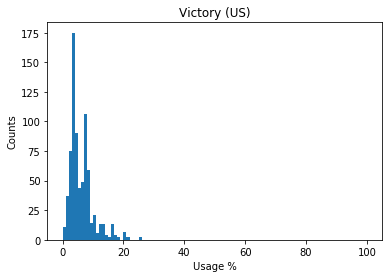

Mean: 6.03941777582063
Standard Dev: 3.848658643422506
Range (3 std dev): 0-17%


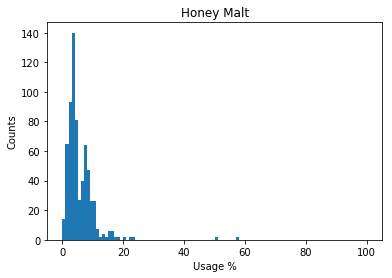

Mean: 5.677921873766566
Standard Dev: 5.218776468861045
Range (3 std dev): 0-21%


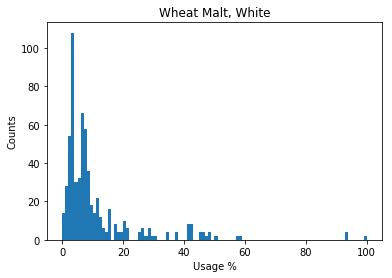

Mean: 11.074757739762502
Standard Dev: 13.938975027600788
Range (3 std dev): 0-52%


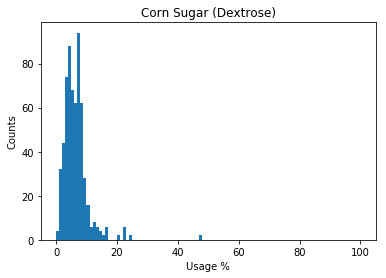

Mean: 6.520167038836915
Standard Dev: 4.243833418699851
Range (3 std dev): 0-19%


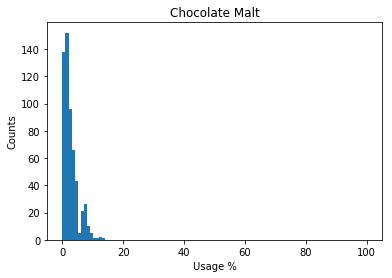

Mean: 2.6961115901388744
Standard Dev: 2.275986956696976
Range (3 std dev): 0-9%


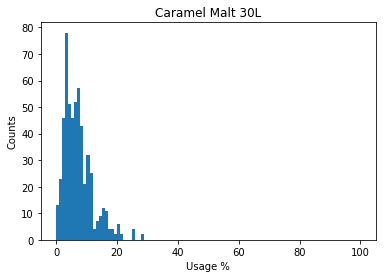

Mean: 7.216943647666346
Standard Dev: 4.689931297063801
Range (3 std dev): 0-21%


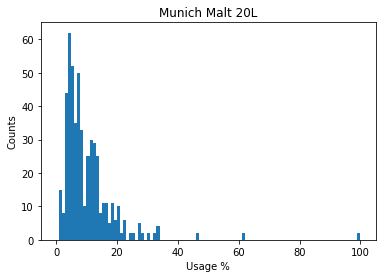

Mean: 10.272010845908794
Standard Dev: 9.251558568832891
Range (3 std dev): 0-38%


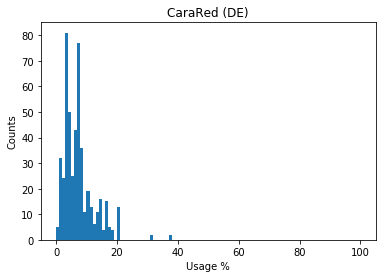

Mean: 7.497862934956071
Standard Dev: 5.134621878269659
Range (3 std dev): 0-22%


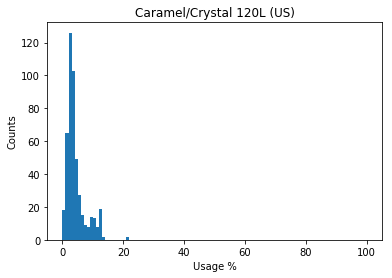

Mean: 4.321520664098724
Standard Dev: 3.1325520779044567
Range (3 std dev): 0-13%


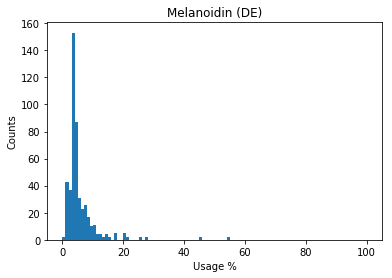

Mean: 5.703346566219473
Standard Dev: 5.692682463754479
Range (3 std dev): 0-22%


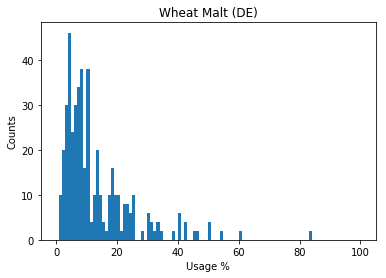

Mean: 13.145303768440558
Standard Dev: 11.762805189794863
Range (3 std dev): 0-48%


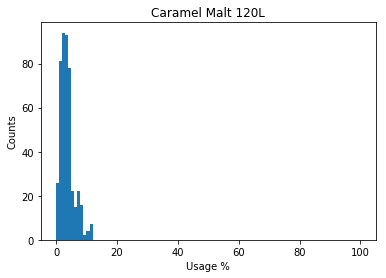

Mean: 3.730598859462286
Standard Dev: 2.236453299479948
Range (3 std dev): 0-10%


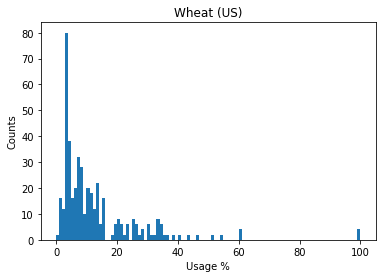

Mean: 12.982720286425007
Standard Dev: 13.948334575309431
Range (3 std dev): 0-54%


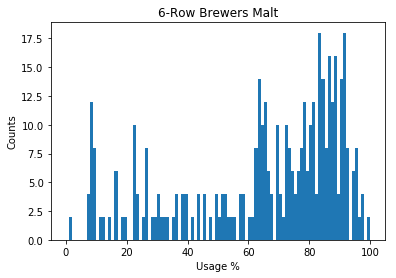

Mean: 65.09302273062175
Standard Dev: 26.10437593020169
Range (3 std dev): 0-100%


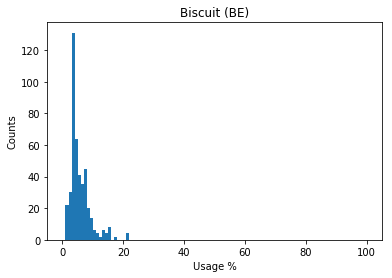

Mean: 5.601785007361871
Standard Dev: 3.3601176420274634
Range (3 std dev): 0-15%


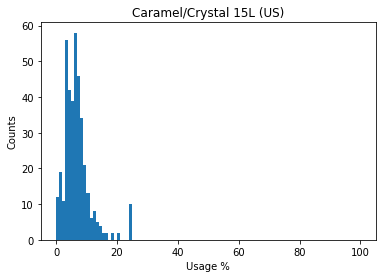

Mean: 6.868508765334507
Standard Dev: 4.392134926945838
Range (3 std dev): 0-20%


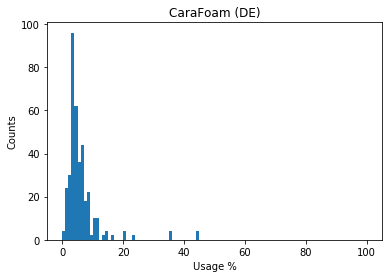

Mean: 6.126417864118125
Standard Dev: 6.050079737843728
Range (3 std dev): 0-24%


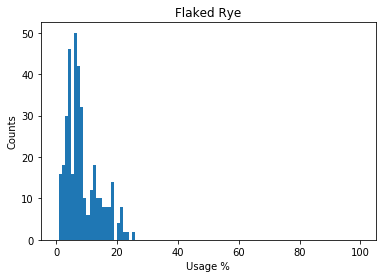

Mean: 8.677175267146067
Standard Dev: 5.3219836861961
Range (3 std dev): 0-24%


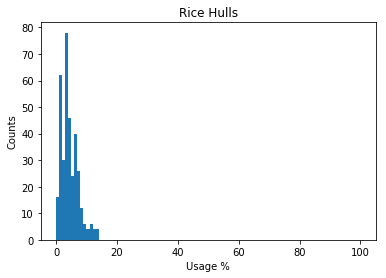

Mean: 4.492518969362691
Standard Dev: 2.7727171492094755
Range (3 std dev): 0-12%


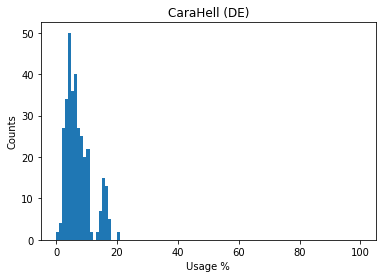

Mean: 7.30050116193079
Standard Dev: 4.153878918735848
Range (3 std dev): 0-19%


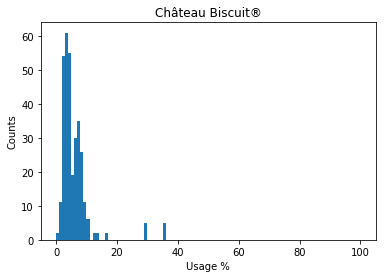

Mean: 6.036897155259856
Standard Dev: 5.388763594828625
Range (3 std dev): 0-22%


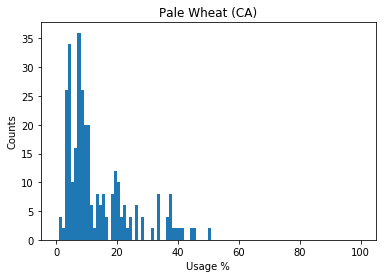

Mean: 13.659894734620888
Standard Dev: 10.807970779714177
Range (3 std dev): 0-46%


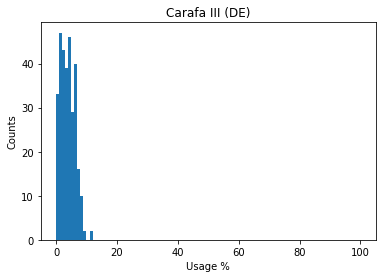

Mean: 3.9323224862144546
Standard Dev: 2.2600602789136417
Range (3 std dev): 0-10%


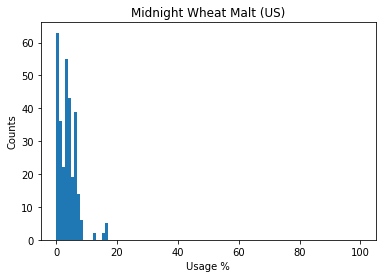

Mean: 3.881721304035238
Standard Dev: 2.9746919872273603
Range (3 std dev): 0-12%


In [51]:
for fermentable_usage in sorted_usage[0:50]:
    # Histogram for the grain usage 
    #plt.title('{} in {}'.format(unique_names[name], styles[style]))
    plt.title('{}'.format(fermentable_usage[0]))
    plt.xlabel('Usage %')
    plt.ylabel('Counts')
    bins = range(0, 101)
    plt.hist(fermentable_usage[1], bins=bins)
    plt.show()
    std_dev = np.std(fermentable_usage[1])
    mean = np.mean(fermentable_usage[1])
    print('Mean: {}'.format(mean))
    print('Standard Dev: {}'.format(std_dev))
    print('Range (3 std dev): {}-{}%'.format(max(0, int(mean - 3 * std_dev)), min(100, int(mean + 3 * std_dev))))